In [132]:
import torch
import numpy as np
import pandas as pd
from sklearn.metrics import precision_recall_curve, roc_curve, auc, average_precision_score, f1_score, ConfusionMatrixDisplay
from bicycle.model import BICYCLE
from pathlib import Path
import matplotlib.pyplot as plt
from bicycle.utils.mask_utils import get_sparsity, above_threshold, string_to_list
import json
from glob import glob

In [133]:
save = False

In [134]:
def agg1(params, param_of_interest):
    params = params.sort_index()
    params["config"] = ["Vanilla", "Bayes prior", "Binary Prior"]
    param_of_interest = "config"
    return params, param_of_interest
def agg2(params, param_of_interest):
    params = params.sort_index()
    return params, param_of_interest
def agg3(params, param_of_interest):
    params = params.sort_index()
    params["Config"] = ["Vanilla\n5 TFs", "Masking\n5 TFs", "Vanilla\n10 TFs", "Masking\n10 TFs"]
    params = params.iloc[[0,2,1,3]]
    param_of_interest = "Config"
    return params, param_of_interest
def agg4(params, param_of_interest):
    params = params.sort_values(param_of_interest)
    params["Config"] = ["Vanilla\n400", "Masking\n400", "Masking\n200", "Masking\n100", "Vanilla\n200", "Vanilla\n100"]
    param_of_interest = "Config"
    params = params.sort_values("Config")
    return params, param_of_interest
def agg5(params, param_of_interest):
    params = params.sort_index()
    if len(params)>4:
        params["pert. Strength"] = (1/10**np.arange(4, -1,-1)).astype(str)
    else:
        params["pert. Strength"] = 1/np.arange(4, 0,-1)

    param_of_interest = "pert. Strength"
    return params, param_of_interest
def agg6(params, param_of_interest):
    params = params.sort_values(param_of_interest)
    params[param_of_interest] = params[param_of_interest].astype(float)
    return params, param_of_interest
functions = {
    "agg1":agg1,
    "agg2":agg2,
    "agg3":agg3,
    "agg4":agg4,
    "agg5":agg5,
    "agg6":agg6,
             }

In [135]:
# get environment
with open("./data/experiment_configs.json", "r") as rf:
    config_sets = json.load(rf)

config_set = config_sets[1]
include = config_set["include"]
id_len = config_set["id_len"]
prefix = config_set["prefix"]
experiment = config_set["experiment"]
param_of_interest = config_set["param_of_interest"]
agg = config_set["function"]

#include = np.array([32,33])
#id_len = 5
#prefix = "test_run_"
#experiment = None
#param_of_interest = "masking_mode"
#agg = None

models_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/models/")
plot_path = Path("/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/plots")
columns = [
     "model_lr",
     "model_n_genes",
     "model_n_samples",
     "model_gt_interv",
    "pretraining_time",
    "training_time",
    "compile",
    "trad_loading",
    "scale_mask",
    "grn_noise_p",
    "n_epochs",
    "use_hard_mask",
    "masking_mode",
    "bin_prior",
    "data_id"
    ]
if not param_of_interest in columns:
    columns.append(param_of_interest)
    print(f"Adding {param_of_interest}")
params = pd.DataFrame(columns=columns)
for dir in plot_path.iterdir():
    if dir.name[:-id_len] != prefix:
         continue
    if int(dir.name[-id_len:]) not in include:
          continue
    print(dir.name)
    if (dir/ "manual_globals.csv").exists():
        params.loc[dir.name] = np.nan
        p = pd.read_csv(dir/"manual_globals.csv", index_col=0)
        available_paras=[n for n in params.columns if n in p.columns]
        params.loc[dir.name, available_paras] = p.loc[dir.name,available_paras]
        continue
    try:
        globs = pd.read_csv(dir/ "globals.csv", delimiter=",").set_index("0", drop=True).T
        available_paras = [n for n in columns if n in globs.columns]
        params.loc[dir.name] = globs[available_paras].iloc[1]
    except FileNotFoundError:
        print(f"globals file for {dir.name} not found!")
        params.loc[dir.name] = np.nan
if experiment == "scalemask":
     params = pd.read_csv(models_path.parent/"param1.csv", index_col=0).sort_values("scale_mask")
    
if agg != None:
     params, param_of_interest = functions[agg](params, param_of_interest)
#params = pd.read_csv(models_path.parent/"manual_params.csv", index_col=0).sort_index()
#add = "test_run_00025"
#available_paras=[n for n in params.columns if n in params1.columns]
#params.loc[add, available_paras] = params1.loc[add,available_paras]

Adding grn_noise_factor
run_007
run_010
run_001
run_006
run_008


In [136]:
'''
ckpts = dict()
for path in models_path.iterdir():
    if int(path.name[-id_len:]) not in include:
          continue
    if path.name[:-id_len] != prefix:
         continue
    ckpt_path = path / "customcheckpoint/last.ckpt"

    if not ckpt_path.exists():
        continue
    print(path.name)
    model = BICYCLE.load_from_checkpoint(ckpt_path)


    ckpts[str(path.name)] = {}
    with torch.no_grad():
        grn = model.gt_beta.copy()
        ckpts[str(path.name)]["grn"] = grn
        if not model.mask is None:
            beta = np.zeros(grn.shape)
            beta[model.mask.cpu().to(bool)] = model.beta_val
            ckpts[str(path.name)]["beta"] = beta
            #plt.hist(beta)
            #plt.show()

        else:
            ckpts[str(path.name)]["beta"] = model.beta.detach().numpy().copy()
        if not model.bayes_prior is None:
            ckpts[str(path.name)]["prior"] = model.bayes_prior.cpu().numpy().copy()
'''

'\nckpts = dict()\nfor path in models_path.iterdir():\n    if int(path.name[-id_len:]) not in include:\n          continue\n    if path.name[:-id_len] != prefix:\n         continue\n    ckpt_path = path / "customcheckpoint/last.ckpt"\n\n    if not ckpt_path.exists():\n        continue\n    print(path.name)\n    model = BICYCLE.load_from_checkpoint(ckpt_path)\n\n\n    ckpts[str(path.name)] = {}\n    with torch.no_grad():\n        grn = model.gt_beta.copy()\n        ckpts[str(path.name)]["grn"] = grn\n        if not model.mask is None:\n            beta = np.zeros(grn.shape)\n            beta[model.mask.cpu().to(bool)] = model.beta_val\n            ckpts[str(path.name)]["beta"] = beta\n            #plt.hist(beta)\n            #plt.show()\n\n        else:\n            ckpts[str(path.name)]["beta"] = model.beta.detach().numpy().copy()\n        if not model.bayes_prior is None:\n            ckpts[str(path.name)]["prior"] = model.bayes_prior.cpu().numpy().copy()\n'

In [137]:
ckpts = dict()
for path in models_path.iterdir():
    if path.name[:-id_len] != prefix:
         continue
    if int(path.name[-id_len:]) not in include:
          continue
    paths = glob(root_dir=path/"customcheckpoint", pathname="./last*.ckpt")
    paths.remove('./last.ckpt')

    if len(paths) ==0:
        print("using last")
        ckpt_path = path / "customcheckpoint/last.ckpt"
        if not ckpt_path.exists():
            continue
    else:
        ckpt_path = path / "customcheckpoint"/ max(paths)
        print(ckpt_path)
    key = str(path.name)
    print(key)
    state = torch.load(ckpt_path, weights_only=False, map_location="cpu")
    print("last epoch: ",state["epoch"])
    if state["epoch"]<500:
         print(f"{key} only has {state['epoch']} epoch.\nWill be removed...")
         params = params.drop(index=key)
         continue
    ckpts[str(path.name)] = {}
    grn = state["hyper_parameters"]["gt_beta"]
    if type(grn) != np.ndarray:
         grn = grn.numpy()
    ckpts[str(path.name)]["grn"] = grn
    if not state["hyper_parameters"]["mask"] is None:
            beta = np.zeros(grn.shape)
            beta[state["hyper_parameters"]["mask"].to(bool)] = state["state_dict"]["beta_val"].numpy()
            ckpts[str(path.name)]["beta"] = beta
    else:
        ckpts[str(path.name)]["beta"] = state["state_dict"]["beta"].numpy()
    prior = state["hyper_parameters"].get("bayes_prior", None)
    if not prior is None:
        ckpts[str(path.name)]["prior"] = prior.numpy()


/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/models/run_007/customcheckpoint/last-v1.ckpt
run_007
last epoch:  9551
/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/models/run_010/customcheckpoint/last-v1.ckpt
run_010
last epoch:  9999
/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/models/run_001/customcheckpoint/last-v2.ckpt
run_001
last epoch:  4999
/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/models/run_006/customcheckpoint/last-v1.ckpt
run_006
last epoch:  9940
/data/toulouse/bicycle/notebooks/experiments/masking/data/model_runs/models/run_008/customcheckpoint/last-v1.ckpt
run_008
last epoch:  9999


In [138]:
n = 1
if param_of_interest != "run_id":
    while params[param_of_interest].duplicated().any():
        params.loc[params[param_of_interest].duplicated(), param_of_interest] += f"."
        n+=1
params

,model_lr,model_n_genes,model_n_samples,model_gt_interv,pretraining_time,training_time,compile,trad_loading,scale_mask,grn_noise_p,n_epochs,use_hard_mask,masking_mode,bin_prior,data_id,grn_noise_factor
run_006,0.001,110,10000,"tensor([[0., 0., 0., 0., 0., 0.],\n [0....",754.5848095417023,9718.803211212158,True,True,1,0.0,10000,False,loss,False,data_run003,0.0
run_007,0.001,110,10000,"tensor([[0., 0., 0., 0., 0., 0.],\n [0....",771.0654075145721,9295.322650671005,True,True,1,0.02066115702479339,10000,False,loss,False,data_run003,0.5
run_008,0.001,110,10000,"tensor([[0., 0., 0., 0., 0., 0.],\n [0....",757.3843262195587,8596.416004657745,True,True,1,0.04132231404958678,10000,False,loss,False,data_run003,1.0
run_001,0.001,110,10000,"tensor([[0., 1., 0., 0., 0., 0.],\n [0....",1000.6491122245789,6445.681981086731,True,True,1,0.01884297520661157,5000,False,loss,False,data_run003,2.0
run_010,0.001,110,10000,"tensor([[0., 0., 0., 0., 0., 0.],\n [0....",834.5337066650391,9847.224287748337,True,True,1,0.2066115702479339,10000,False,loss,False,data_run003,5.0


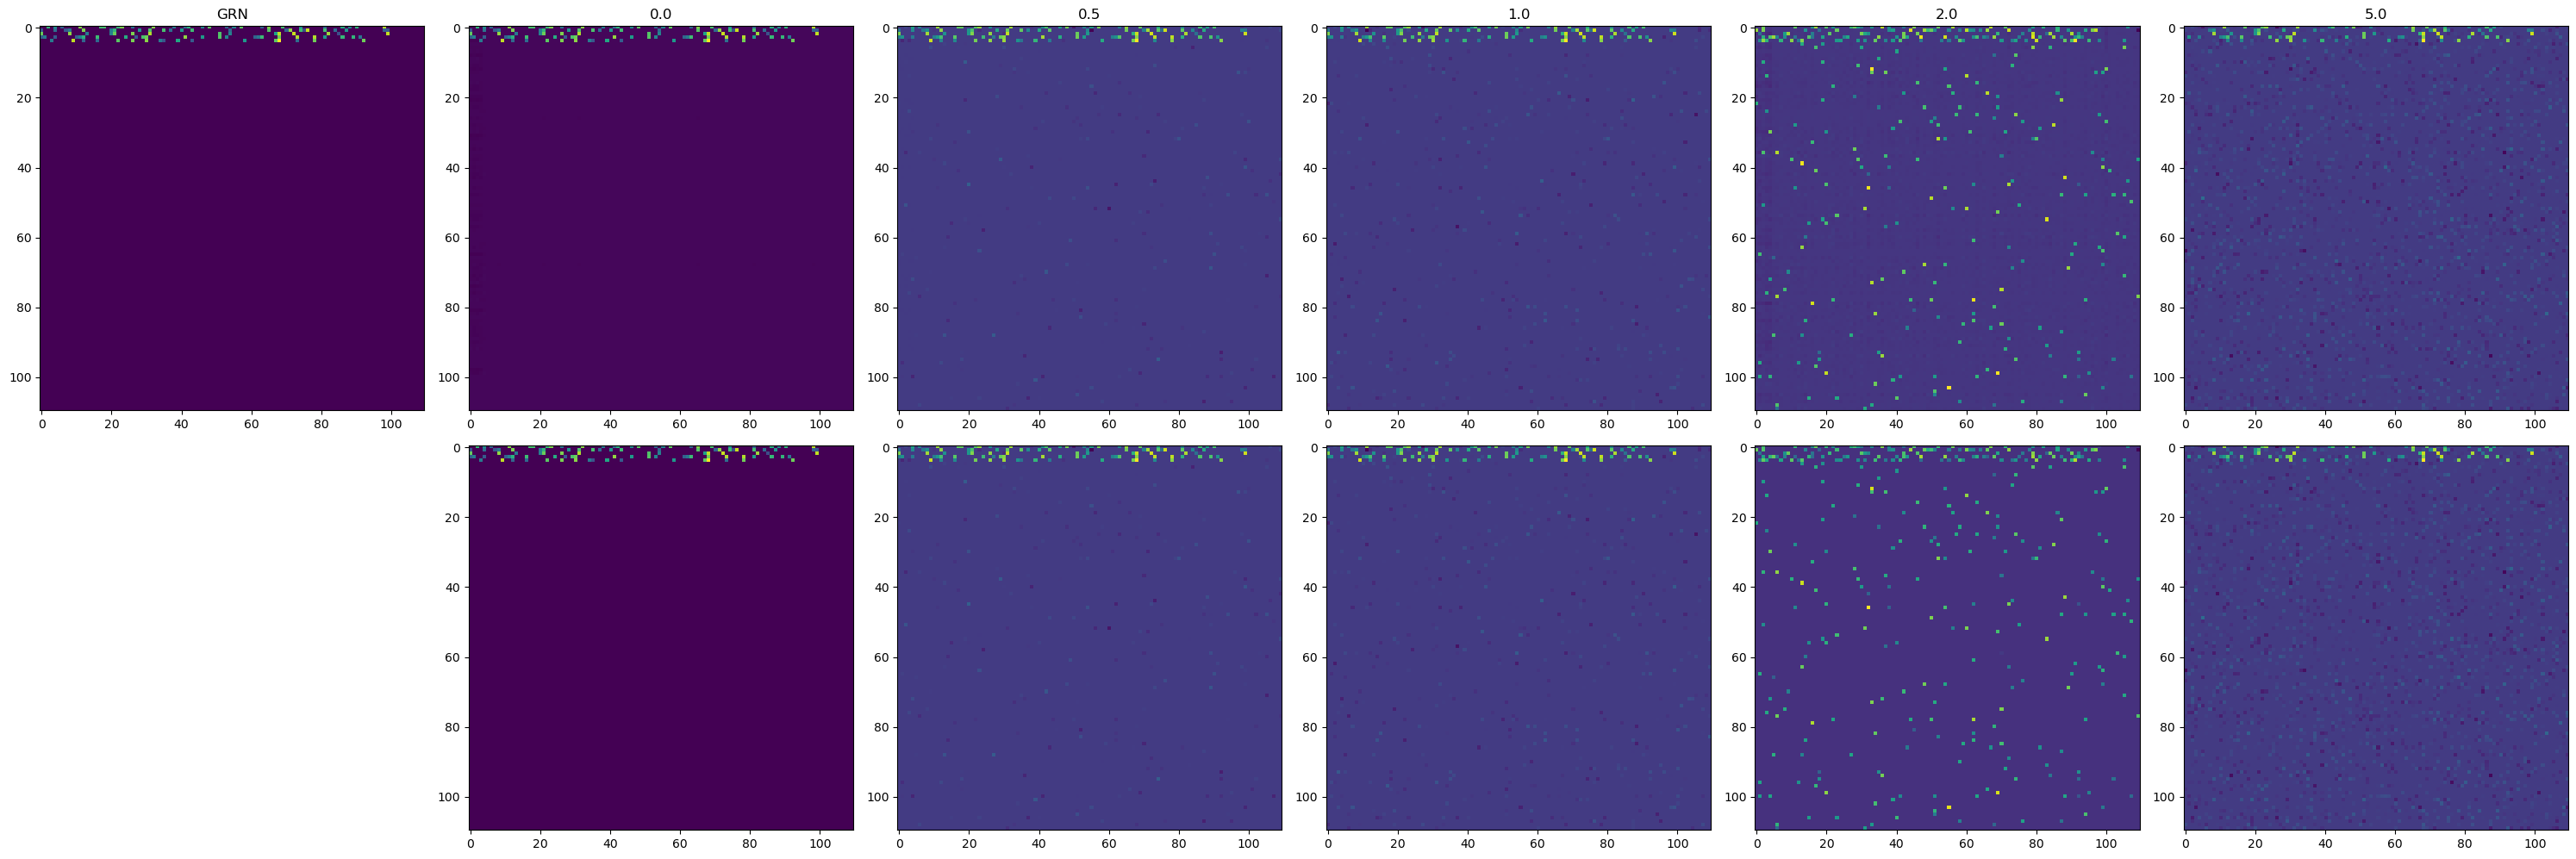

In [139]:
fig, ax = plt.subplots(nrows=2, ncols=len(params)+1, figsize = (30, 10))
ax[0, 0].imshow(grn)
ax[0, 0].set_title("GRN")
for n, run_id in enumerate(params.index):
    ax[0, n+1].imshow(ckpts[run_id]["beta"])
    ax[0, n+1].set_title(params.loc[run_id,param_of_interest])
    try:
        ax[1, n+1].imshow(ckpts[run_id]["prior"])
    except KeyError:
        print("No prior")
fig.delaxes(ax[1,0])
fig.tight_layout()

run_006
run_007
run_008
run_001
run_010


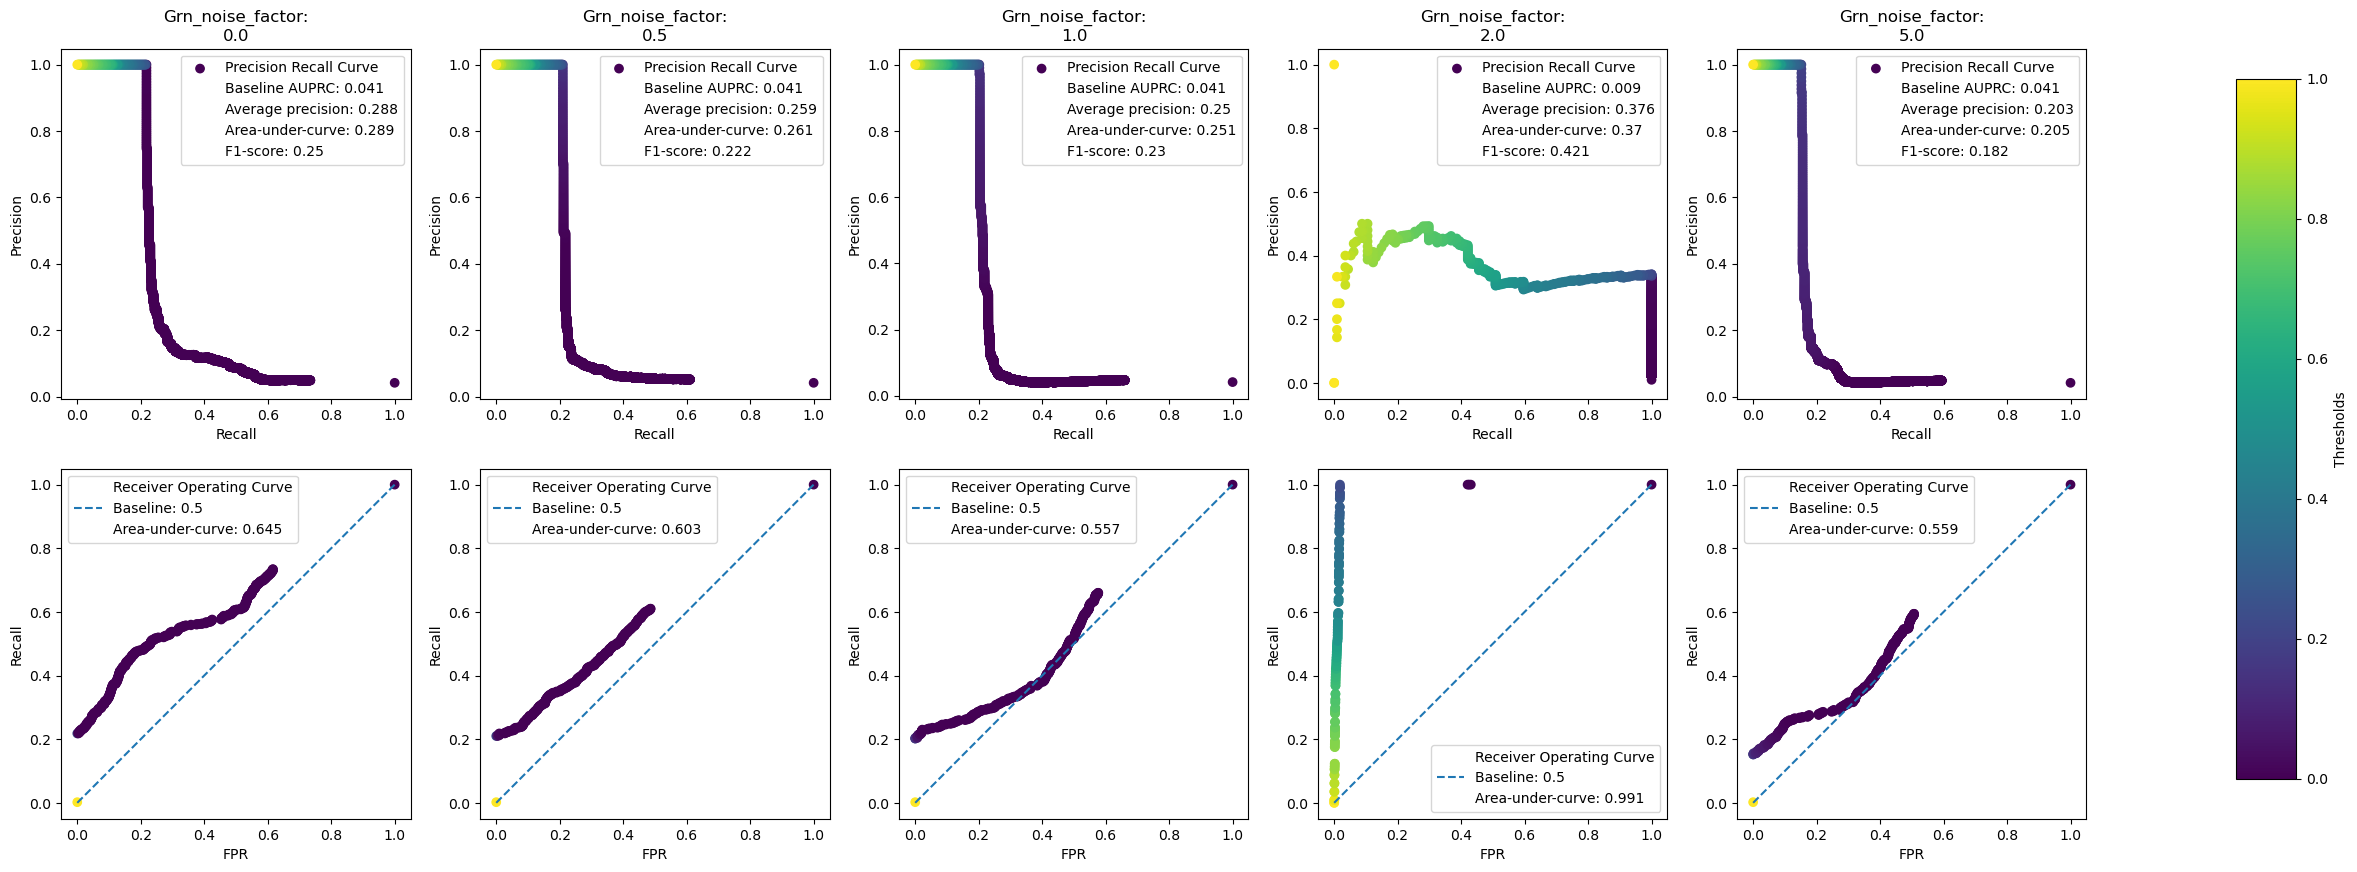

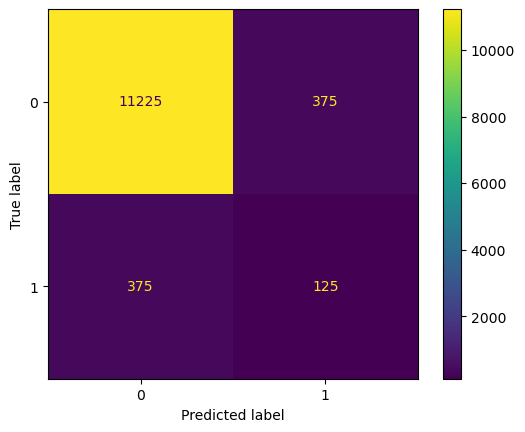

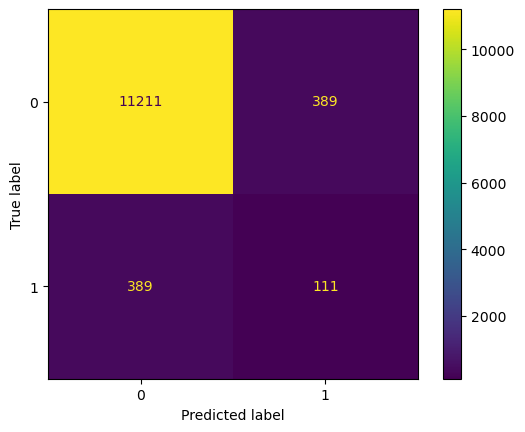

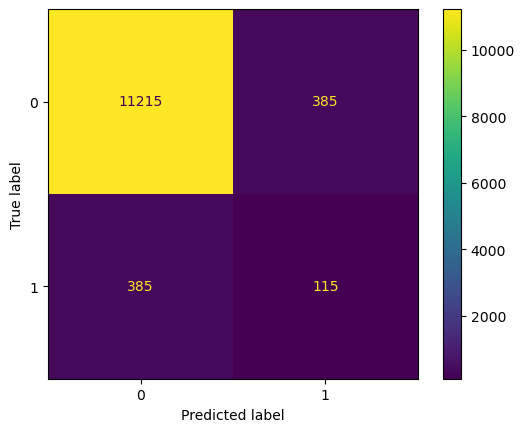

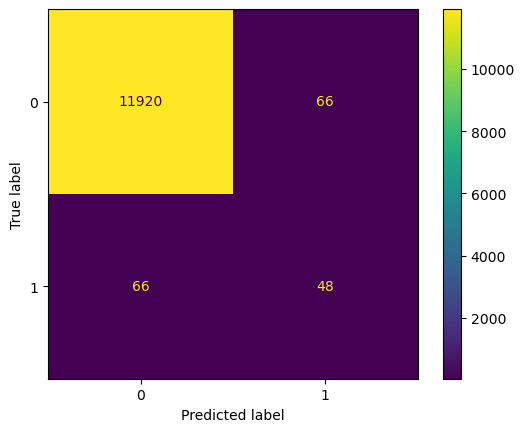

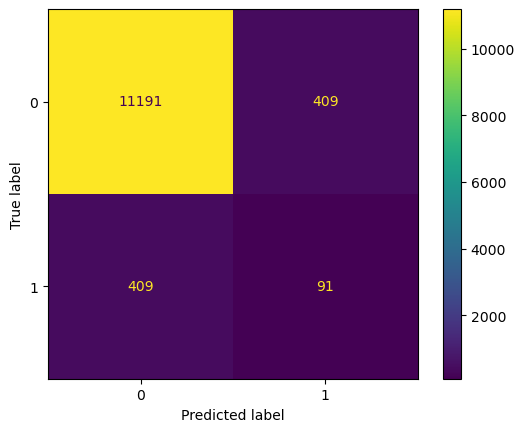

In [143]:
fig, ax=plt.subplots(nrows=2, ncols=len(ckpts.keys()), figsize=(len(ckpts.keys())*6, 10))
params["average_precision"] = np.empty(len(params))
params["auprc"] = np.empty(len(params))
params["f1"] = np.empty(len(params))
params["auroc"] = np.empty(len(params))
for n, run_id in enumerate(params.index):
    max_f1 = False

    print(run_id)
    beta = ckpts[run_id]["beta"]
    grn = ckpts[run_id]["grn"]
    grn=grn.flatten()
    beta=beta.flatten()
    # normalize to [0, 1]
    grn = (grn > 0).astype(int)
    beta[beta<0] = 0
    beta = beta/np.max(beta)
    precision, recall, prc_thresholds = precision_recall_curve(
        y_true=grn,
        y_score=beta,
        )
    # baseline is positive samples/total samples (saito et al.) = sparsity
    baseline_AUPRC = get_sparsity(ckpts[run_id]["grn"])
    ConfusionMatrixDisplay.from_predictions(y_true=grn, y_pred=above_threshold(beta, percentile=100-100*baseline_AUPRC)).im_
    if max_f1:
        f1_scores = [f1_score(grn, above_threshold(beta, threshold=threshold)) for threshold in prc_thresholds]
        max_f1 = max(f1_scores)
    else:
        max_f1 = f1_score(grn, above_threshold(beta, percentile=100-baseline_AUPRC*100))
        
    auprc = auc(x=recall, y=precision)
    average_precision = average_precision_score(grn, beta)
    im = ax[0, n].scatter(recall,precision, label = "Precision Recall Curve", c = np.append(0, prc_thresholds), cmap = plt.colormaps["viridis"])
    ax[0, n].plot([], []," ",  label=f"Baseline AUPRC: {np.round(baseline_AUPRC, 3)}")
    ax[0, n].plot([], []," ",  label=f"Average precision: {np.round(average_precision, 3)}")
    ax[0, n].plot([], []," ",  label=f"Area-under-curve: {np.round(auprc, 3)}")
    ax[0, n].plot([], []," ",  label=f"F1-score: {np.round(max_f1, 3)}")
    
    ax[0, n].set_ylabel("Precision")
    ax[0, n].set_xlabel("Recall")
    if not type(params.loc[run_id, param_of_interest]) is str:
        ax[0, n].set_title(f"{param_of_interest.capitalize()}:\n{round(float(params.loc[run_id, param_of_interest]), 3)}")
    else:
        ax[0, n].set_title(f"{params.loc[run_id, param_of_interest]}")
    #ax[0, n].set_title(f"{run_id}")
    ax[0, n].legend()
    
    fpr, tpr, roc_thresholds=roc_curve(y_true=grn, y_score=beta)
    auroc = auc(fpr, tpr)
    ax[1, n].scatter(fpr,tpr, label = "Receiver Operating Curve", c =roc_thresholds, cmap = plt.colormaps["viridis"])
    ax[1, n].plot([0,1],[0,1],"--", label = "Baseline: 0.5")
    ax[1, n].plot([], []," ",  label=f"Area-under-curve: {np.round(auroc, 3)}")

    ax[1, n].set_ylabel("Recall")
    ax[1, n].set_xlabel("FPR")
    ax[1, n].legend()

    params.loc[run_id, "average_precision"] = average_precision
    params.loc[run_id, "auprc"] = auprc
    params.loc[run_id, "f1"] = max_f1
    params.loc[run_id, "auroc"] = auroc

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes((0.85, 0.15, 0.02, 0.7))
fig.colorbar(im, cax = cbar_ax, label="Thresholds")

if save:
    print("Saving!")
    fig.savefig(f"./presentation/{experiment}_metrics_curves.pdf", bbox_inches = "tight", pad_inches = 0)


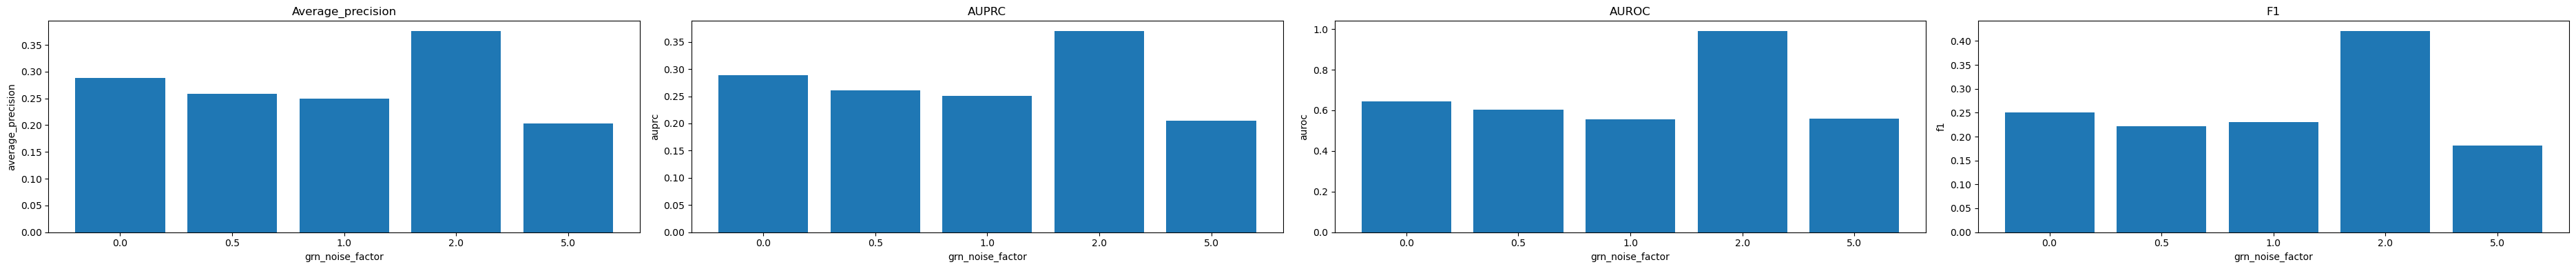

In [141]:
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(len(ckpts.keys())*len(params)*1.5, 4))
ax = ax.flatten()
for n, metric in enumerate(["average_precision","auprc","auroc", "f1"]):
    if not type(params.loc[run_id, param_of_interest]) is float or params.loc[run_id, param_of_interest] is np.nan:
        ax[n].bar(params[param_of_interest].astype(str),
                  params[metric])
    else:
        ax[n].bar(np.round(params[param_of_interest].astype(float), 3).astype(str), params[metric])
    if "_" in metric:
        ax[n].set_title(metric.capitalize())
    else:
        ax[n].set_title(metric.upper())
    ax[n].set_ylabel(metric)
    ax[n].set_xlabel(param_of_interest)
fig.tight_layout()
if save:
    print("Saving!")
    fig.savefig(f"./presentation/{experiment}_metrics_bar.pdf", bbox_inches = "tight", pad_inches = 0)